https://www.youtube.com/watch?v=RDZUdRSDOok

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances

C:\Users\aniru\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [138]:
s = '''2 2
3 1
5 3
4 15
11 12
12 13
3 4
13 12
13 14'''

In [139]:
sl = s.split('\n')
dt = {chr(65+i):list(map(float,sl[i].split(' '))) for i in range(len(sl))}
dt

{'A': [2, 2],
 'B': [3, 1],
 'C': [5, 3],
 'D': [4, 15],
 'E': [11, 12],
 'F': [12, 13],
 'G': [3, 4],
 'H': [13, 12],
 'I': [13, 14]}

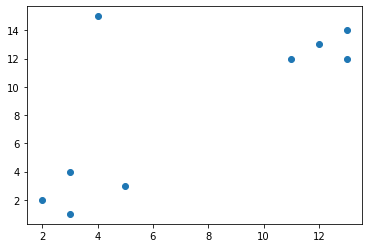

In [140]:

data = list(dt.values())
x = np.array([d[0] for d in data])
y = np.array([d[1] for d in data])

plt.scatter(x, y)
plt.show()

In [142]:
df = pd.DataFrame(data=np.array(list(dt.values())),columns=['X','Y'])
df

,X,Y
0,2,2
1,3,1
2,5,3
3,4,15
4,11,12
5,12,13
6,3,4
7,13,12
8,13,14


In [3]:
s = '''1 2
3 4
2.5 4
1.5 2.5
3 5
2.8 4.5
2.5 4.5
1.2 2.5
1 3
1 5
1 2.5
5 6
4 3'''
sl = s.split('\n')
dt = {chr(65+i):list(map(float,sl[i].split(' '))) for i in range(len(sl))}
df = pd.DataFrame(data=np.array(list(dt.values())),columns=['X','Y'])
df

,X,Y
0,1.0,2.0
1,3.0,4.0
2,2.5,4.0
3,1.5,2.5
4,3.0,5.0
5,2.8,4.5
6,2.5,4.5
7,1.2,2.5
8,1.0,3.0
9,1.0,5.0


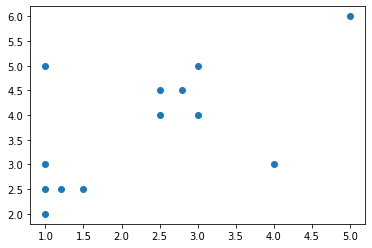

In [7]:
data = list(dt.values())
x = np.array([d[0] for d in data])
y = np.array([d[1] for d in data])

plt.scatter(x, y)
plt.show()

In [4]:
def manhatan(x,y):
    return sum(abs(value1 - value2) for value1, value2 in zip(x, y))
def check_attr(d):
    if(d['isCore']) : return 'Core'
    if(d['isBorder']): return 'Border'
    if(d['isNoise']): return 'Noise'
    
def grow_cluster(clust_data, neighborhood, cluster_labels,cluster_label):
    for p in neighborhood:
        if(cluster_labels[p] == -1):
            if(clust_data[p]['isBorder']):
                print('----------{} is in neighborhood adding to cluster {}'.format(p,cluster_label))
                cluster_labels[p] = cluster_label
            if(clust_data[p]['isCore']):
                print('----------{} is in neighborhood adding to cluster {}'.format(p,cluster_label))
                print('-------{} is also a core point so visiting its neighbors'.format(p))
                cluster_labels[p] = cluster_label
                grow_cluster(clust_data, clust_data[p]['neighbors'], cluster_labels,cluster_label)
                print('-------done visiting neighbor core point',p)
        else: print('-------- {} is already part of cluster {}'.format(p,cluster_labels[p]))
def dbscan(data,eps,minPts,build_dist_mat=True,distance='euclidean'):
    if(build_dist_mat):
        if(distance=='euclidean'):
            distMat = euclidean_distances(data)
        else:
            ll = len(data)
            distMat = [[0]*ll for i in range(ll)]
            for i in range(ll):
                for j in range(ll):
                    if(i==j): 
                        distMat[i][j] = 0
                        continue
                    else:
                        distMat[i][j] = manhatan(data[i],data[j])
                    
    else:
        distMat = data
        
    distMat = np.round(distMat,3)
    
    print('-----Step 1, euclidian distance matrix:')
    print(pd.DataFrame(data=distMat))
        
    clust_data = {}
    for i in range(df.shape[0]):
        clust_data[i] = {'neighbors':set(),'isCore':False,'isBorder':False,'isNoise':True}
    visited = [0]*df.shape[0]
    
    print('--- Step 2, identifying core & border points')
    # mark core points
    for i in range(df.shape[0]):
        print('---visiting point',i)
        for j in range(df.shape[0]):
            if(i == j): continue
            if(distMat[i][j] <= eps):
                print('------D[{},{}] = {} < {}(eps) so adding {} to neighborhood of {}'.format(i,j,distMat[i][j],eps,j,i ))
                clust_data[i]['neighbors'].add(j)
        print('------N[{}] is'.format(i),clust_data[i]['neighbors'])
        if(len(clust_data[i]['neighbors'])+1 >= minPts): 
            
            print('--------and contains minimum points so marking it as **core point**'.format(i,clust_data[i]['neighbors']))
            clust_data[i]['isCore'] = True
            clust_data[i]['isNoise'] = False
            
    corePoints = {k:v for k,v in clust_data.items() if v['isCore']}
    
    print('---- Step 2.5 marking border points')
    # mark border points
    for k,v in corePoints.items():
        
        for bpts in corePoints[k]['neighbors']:
            if(not clust_data[bpts]['isCore'] and not clust_data[bpts]['isBorder']):
                print('----------since {} is not a core point and is in neighborhood of {} it is a border point to core point {}'.format(bpts,k,k))
                clust_data[bpts]['isBorder'] = True
                clust_data[bpts]['isNoise'] = False
                
    cldf = pd.DataFrame(data = [[i,clust_data[i]['neighbors'],len(clust_data[i]['neighbors'])+1,check_attr(clust_data[i])] for i in range(len(data))],columns = ['point','neighbors','density','attribute'])
    print(cldf)
    # build clusters
    cluster_labels = [-1]*df.shape[0]
    cluster = 0
    print('---- Step 3, building cluster. core points to be visited are:',corePoints.keys())
    for k,v in corePoints.items():
        print('---starting with cluster',cluster)
        print('---visiting core point',k, 'neighborhood N[{}] is'.format(k),corePoints[k]['neighbors'])
        # if not already a part of a cluster then add it to a cluster
        if(cluster_labels[k] == -1):
            print('------core point {} doesnt belong to any cluster yet , adding to cluster{}'.format(k,cluster))
            cluster_labels[k] = cluster
            grow_cluster(clust_data,corePoints[k]['neighbors'],cluster_labels,cluster)
            cluster += 1
        else:
            print('---{} is already part of cluster {}'.format(k,cluster_labels[k]))
    cldf = pd.DataFrame(data = [[i,clust_data[i]['neighbors'],len(clust_data[i]['neighbors'])+1,check_attr(clust_data[i]),cluster_labels[i]] for i in range(len(data))],columns = ['point','neighbors','density','attribute','cluster'])
    print(cldf)
    
    return cluster_labels

In [144]:
dbscan(df.values, 3, 4)

-----Step 1, euclidian distance matrix:
        0       1       2       3       4       5       6       7       8
0   0.000   1.414   3.162  13.153  13.454  14.866   2.236  14.866  16.279
1   1.414   0.000   2.828  14.036  13.601  15.000   3.000  14.866  16.401
2   3.162   2.828   0.000  12.042  10.817  12.207   2.236  12.042  13.601
3  13.153  14.036  12.042   0.000   7.616   8.246  11.045   9.487   9.055
4  13.454  13.601  10.817   7.616   0.000   1.414  11.314   2.000   2.828
5  14.866  15.000  12.207   8.246   1.414   0.000  12.728   1.414   1.414
6   2.236   3.000   2.236  11.045  11.314  12.728   0.000  12.806  14.142
7  14.866  14.866  12.042   9.487   2.000   1.414  12.806   0.000   2.000
8  16.279  16.401  13.601   9.055   2.828   1.414  14.142   2.000   0.000
--- Step 2, identifying core & border points
---visiting point 0
------D[0,1] = 1.414 < 3(eps) so adding 1 to neighborhood of 0
------D[0,6] = 2.236 < 3(eps) so adding 6 to neighborhood of 0
------N[0] is {1, 6}
---visit

[0, 0, 0, -1, 1, 1, 0, 1, 1]

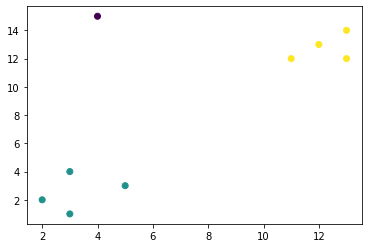

In [145]:
plt.scatter(
    df['X'],
    df['Y'],
    c = [0, 0, 0, -1, 1, 1, 0, 1, 1]
)

In [43]:
from sklearn.cluster import DBSCAN

In [135]:
dbs = DBSCAN(eps=3, min_samples=4)
dbs.fit(list(dt.values()))
dbs.labels_

array([ 0,  0,  0,  0, -1,  1,  1,  1,  1], dtype=int64)

In [6]:
dbscan(df.values, 0.6,4)

-----Step 1, euclidian distance matrix:
       0      1      2      3      4      5      6      7      8      9   \
0   0.000  2.828  2.500  0.707  3.606  3.081  2.915  0.539  1.000  3.000   
1   2.828  0.000  0.500  2.121  1.000  0.539  0.707  2.343  2.236  2.236   
2   2.500  0.500  0.000  1.803  1.118  0.583  0.500  1.985  1.803  1.803   
3   0.707  2.121  1.803  0.000  2.915  2.385  2.236  0.300  0.707  2.550   
4   3.606  1.000  1.118  2.915  0.000  0.539  0.707  3.081  2.828  2.000   
5   3.081  0.539  0.583  2.385  0.539  0.000  0.300  2.561  2.343  1.868   
6   2.915  0.707  0.500  2.236  0.707  0.300  0.000  2.385  2.121  1.581   
7   0.539  2.343  1.985  0.300  3.081  2.561  2.385  0.000  0.539  2.508   
8   1.000  2.236  1.803  0.707  2.828  2.343  2.121  0.539  0.000  2.000   
9   3.000  2.236  1.803  2.550  2.000  1.868  1.581  2.508  2.000  0.000   
10  0.500  2.500  2.121  0.500  3.202  2.691  2.500  0.200  0.500  2.500   
11  5.657  2.828  3.202  4.950  2.236  2.663  2.

[1, 0, 0, 1, 0, 0, 0, 1, 1, -1, 1, -1, -1]

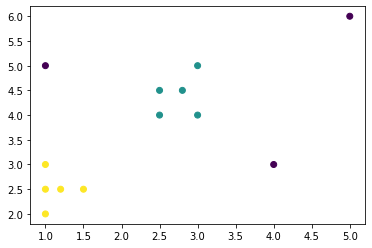

In [8]:
plt.scatter(
    df['X'],
    df['Y'],
    c = [1, 0, 0, 1, 0, 0, 0, 1, 1, -1, 1, -1, -1]
)